In [165]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bayes_functions import probability, conditional_probability, condition_indices

In [166]:
import bayes_functions as bf # Import the module initially
# reload the module to get the updated version
import importlib
importlib.reload(bf)

<module 'bayes_functions' from 'c:\\Users\\jonat\\Python\\bayes\\bayes_functions.py'>

In [167]:
d_prescott_career = pd.read_csv(r"C:\Users\jonat\OneDrive\projects\prize_picks\data\dak_prescott_career_game_logs.txt")

d_prescott_career.head()

,Rk,Year,Date,G#,Week,Age,Tm,Unnamed: 7,Opp,Result,...,FR,Yds.4,TD.4,Num,Pct,Num.1,Pct.1,Num.2,Pct.2,Status
0,1.0,2016.0,2016-09-11,1.0,1.0,23.044,DAL,NaN,NYG,L 19-20,...,0,0,0,78,100%,0,0%,0,0%,NaN
1,2.0,2016.0,2016-09-18,2.0,2.0,23.051,DAL,@,WAS,W 27-23,...,0,0,0,68,100%,0,0%,0,0%,NaN
2,3.0,2016.0,2016-09-25,3.0,3.0,23.058,DAL,NaN,CHI,W 31-17,...,0,0,0,67,99%,0,0%,0,0%,NaN
3,4.0,2016.0,2016-10-02,4.0,4.0,23.065,DAL,@,SFO,W 24-17,...,0,0,0,76,100%,0,0%,0,0%,NaN
4,5.0,2016.0,2016-10-09,5.0,5.0,23.072,DAL,NaN,CIN,W 28-14,...,1,0,0,57,100%,0,0%,0,0%,NaN


In [168]:
# remove any rows where dak was on injured reserve or inactive:

d_prescott_career = d_prescott_career.loc[(
    (d_prescott_career['Yds'] != 'Injured Reserve') & (d_prescott_career['Yds'] != 'Inactive')
)]

# remove last row

d_prescott_career.drop(132, inplace = True)

In [169]:
d_prescott_career.columns

Index(['Rk', 'Year', 'Date', 'G#', 'Week', 'Age', 'Tm', 'Unnamed: 7', 'Opp',
       'Result', 'GS', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Rate', 'Sk',
       'Yds.1', 'Y/A', 'AY/A', 'Att.1', 'Yds.2', 'Y/A.1', 'TD.1', 'Tgt', 'Rec',
       'Yds.3', 'Y/R', 'TD.2', 'Ctch%', 'Y/Tgt', '2PM', 'TD.3', 'Pts', 'Fmb',
       'FL', 'FF', 'FR', 'Yds.4', 'TD.4', 'Num', 'Pct', 'Num.1', 'Pct.1',
       'Num.2', 'Pct.2', 'Status'],
      dtype='object')

In [170]:
# rename unamed: 7 to Home, with a True or False value
d_prescott_career.rename(columns = {'Unnamed: 7': 'Home'}, inplace = True)

# Iterating over the DataFrame rows
for index, row in d_prescott_career.copy().iterrows():

    # create a column of True or False values for Home:
    if row['Home'] == '@':
        d_prescott_career.loc[index, 'Home'] = False
    else:
        d_prescott_career.loc[index, 'Home'] = True

    # Split the 'Result' column's value by hyphen and space
    results_list = re.split(r'[- ]', row['Result'])
    
    # Assigning the split values back to the DataFrame
    if len(results_list) == 3:  # Ensure there are 3 parts in the result (e.g., 'W 20-17')
        d_prescott_career.loc[index, 'Outcome'] = results_list[0]  # 'W' or 'L'
        d_prescott_career.loc[index, 'Team_Score'] = float(results_list[1])  # '20'
        d_prescott_career.loc[index, 'Opponent_Score'] = float(results_list[2])  # '17'
        d_prescott_career.loc[index, 'Point Total'] = float(results_list[1]) + float(results_list[2])
        d_prescott_career.loc[index, 'Margin'] = float(results_list[1]) - float(results_list[2])

# convert passing yards to a float rather than a string
d_prescott_career['Yds'] = pd.to_numeric(d_prescott_career['Yds'], errors='coerce')
        
# Inspecting the DataFrame
d_prescott_career.tail()

,Rk,Year,Date,G#,Week,Age,Tm,Home,Opp,Result,...,Num.1,Pct.1,Num.2,Pct.2,Status,Outcome,Team_Score,Opponent_Score,Point Total,Margin
127,128.0,2023.0,2023-12-17,14.0,15.0,30.141,DAL,False,BUF,L 10-31,...,0,0%,0,0%,NaN,L,10.0,31.0,41.0,-21.0
128,129.0,2023.0,2023-12-24,15.0,16.0,30.148,DAL,False,MIA,L 20-22,...,0,0%,0,0%,NaN,L,20.0,22.0,42.0,-2.0
129,130.0,2023.0,2023-12-30,16.0,17.0,30.154,DAL,True,DET,W 20-19,...,0,0%,0,0%,NaN,W,20.0,19.0,39.0,1.0
130,131.0,2023.0,2024-01-07,17.0,18.0,30.162,DAL,False,WAS,W 38-10,...,0,0%,0,0%,NaN,W,38.0,10.0,48.0,28.0
131,132.0,2024.0,2024-09-08,1.0,1.0,31.041,DAL,False,CLE,W 33-17,...,0,0%,0,0%,NaN,W,33.0,17.0,50.0,16.0


In [171]:
d_prescott_career.describe()

,Rk,Year,G#,Week,Age,Yds,Team_Score,Opponent_Score,Point Total,Margin
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,64.008696,2019.434783,8.626087,9.226087,26.535217,257.721739,27.156522,20.869565,48.026087,6.286957
std,40.137154,2.435593,4.865671,5.288287,2.437948,85.006248,12.086379,9.723837,15.082499,15.930642
min,1.000000,2016.000000,1.000000,1.000000,23.044000,37.000000,0.000000,0.000000,6.000000,-32.000000
25%,29.500000,2017.000000,4.000000,4.000000,24.137500,207.500000,19.000000,15.500000,39.500000,-3.500000
50%,58.000000,2019.000000,9.000000,10.000000,26.111000,249.000000,28.000000,20.000000,47.000000,6.000000
75%,101.000000,2022.000000,13.000000,14.000000,29.065000,293.500000,35.500000,27.500000,58.500000,18.000000
max,132.000000,2024.000000,17.000000,18.000000,31.041000,502.000000,56.000000,49.000000,87.000000,42.000000


In [172]:
# Want to find the probability of over 230 yards for games with a score total of 45.5, where the cowboys won by 6.5

print(f"probability Dak passes for more than 250 yards in a game: {bf.probability(d_prescott_career, 'Yds', 'geq', 250)}")

print(f"probability Dak passes for more than 250 yards in a win: {bf.conditional_probability(d_prescott_career, 'Yds', 'geq', 250, 'Outcome', 'eq', 'W')}")

print(f"probability Dak passes for more than 250 yards at home: {bf.conditional_probability(d_prescott_career, 'Yds', 'geq', 250, 'Home', 'eq', True)}")

print(f"probability Dak passes for more than 250 yards in a +6.5 point victory: {bf.conditional_probability(d_prescott_career, 'Yds', 'geq', 250, 'Margin', 'in_range', (5, 8))}")

print(f"probability Dak passes for more than 250 yards in a game with 48.5 points : {bf.conditional_probability(d_prescott_career, 'Yds', 'geq', 250, 'Point Total', 'in_range', (42.5, 50.5) )}")

probability Dak passes for more than 250 yards in a game: 0.4956521739130435
probability Dak passes for more than 250 yards in a win: 0.527027027027027
probability Dak passes for more than 250 yards at home: 0.5517241379310345
probability Dak passes for more than 250 yards in a +6.5 point victory: 0.6111111111111112
probability Dak passes for more than 250 yards in a game with 48.5 points : 0.41379310344827586


<AxesSubplot:xlabel='Outcome', ylabel='Yds'>

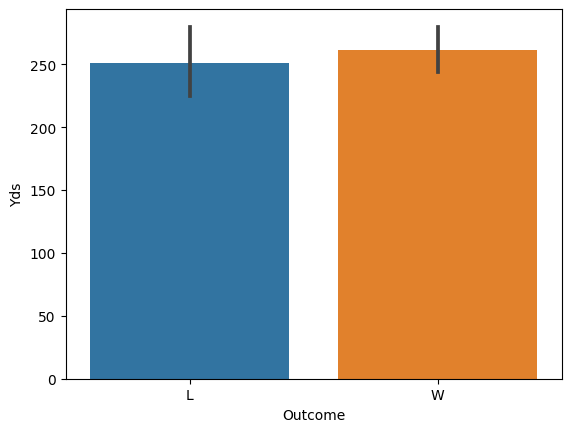

In [173]:
# analysis for total points, wins, and margin of victory for passing yards

sns.barplot(data = d_prescott_career, x = 'Outcome', y = 'Yds')

<AxesSubplot:xlabel='Margin', ylabel='Yds'>

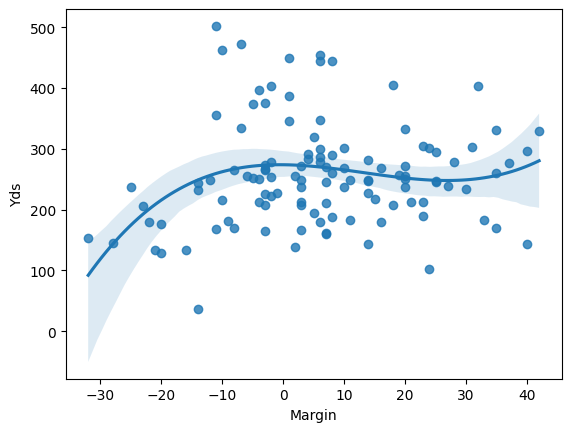

In [174]:
# regression analysis for margin versus passing yards
# want to find best fit

sns.regplot(data = d_prescott_career, x = 'Margin', y = 'Yds', order = 3)

<AxesSubplot:xlabel='Point Total', ylabel='Yds'>

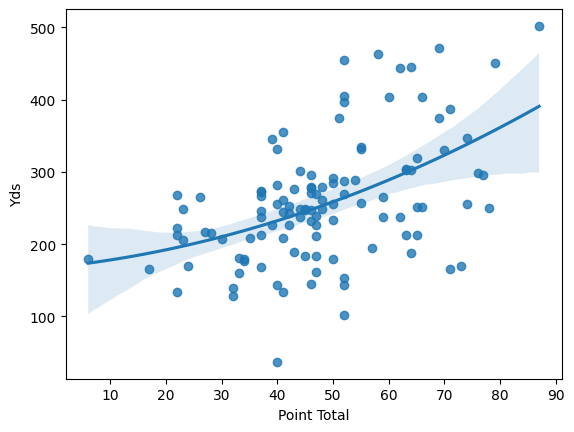

In [175]:
# regression analysis for point total versus passing yards
sns.regplot(data = d_prescott_career, x = 'Point Total', y = 'Yds', order = 2)


In [176]:
# let's focus in on games with a margin of around +6.5 with about 46.5 points. 

d_prescott_career = d_prescott_career.loc[
    (d_prescott_career['Margin'] >= 43.5) &
]

0.6111111111111112

In [135]:
# let's create a time series of his passing yards over the course of his career
historical_passing = d_prescott_career[['Date', 'Yds']].copy()

weeks_injured = 0
# set time column, and replace injured with zero
historical_passing['time'] = 0
for index, row in historical_passing.copy().iterrows():
    historical_passing.loc[index, 'time'] = index
    if row['Yds'] == 'Injured Reserve' or row['Yds'] == 'Inactive':
        historical_passing.loc[index, 'Yds'] = 0
        weeks_injured += 1

print(f" Dak Prescott had been inactive for {weeks_injured} weeks")

# drop the final entry which is a totals value
historical_passing.drop(132, inplace = True)

historical_passing.head()

# potentially create an indicator where the new season started

 Dak Prescott had been inactive for 17 weeks


,Date,Yds,time
0,2016-09-11,227,0
1,2016-09-18,292,1
2,2016-09-25,248,2
3,2016-10-02,245,3
4,2016-10-09,227,4


In [142]:
historical_passing['Yds'] = historical_passing['Yds'].astype(float)
historical_passing['time'] = historical_passing['time'].astype(float)


<AxesSubplot:xlabel='time', ylabel='Yds'>

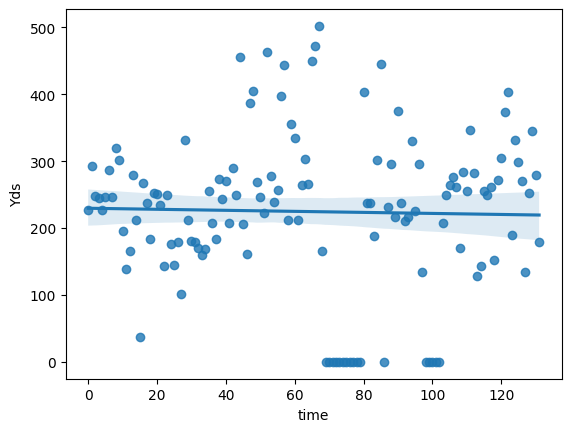

In [148]:
# time series for the data
sns.regplot(data = historical_passing, x = 'time', y = 'Yds')